In [ ]:



import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
import shutil
import cv2
from statistics import mean
from tqdm import tqdm
from tensorflow.keras import applications
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder,image
from sklearn.metrics import accuracy_score,classification_report, f1_score

In [ ]:
image_dir = '../input/breakhis/BreaKHis_v1'
data_path = '../input/breakhis/Folds.csv'


# defining the class names
class_names = ['malignant', 'benign']
print(class_names)

['malignant', 'benign']


In [ ]:
data = pd.read_csv(data_path)
data.head(5)
data.drop

<bound method DataFrame.drop of        fold  mag    grp                                           filename
0         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
...     ...  ...    ...                                                ...
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...

[39545 rows x 4 columns]>

In [ ]:
data['fold'].value_counts()

1    7909
2    7909
3    7909
4    7909
5    7909
Name: fold, dtype: int64

In [ ]:
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

In [ ]:
data.head(6)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png


In [ ]:
data = data.loc[data['fold']== 1]
data.shape
data.reset_index(drop=True)
data_copy = data


In [ ]:
# Create a new directory to store all available images
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)

In [ ]:

data['path'][0]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'

In [ ]:
print(len(data))

7909


In [ ]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

for i in range(len(data)):
    src = os.path.join('../input/breakhis/BreaKHis_v1', data['path'][i])
    dst = os.path.join('./all_images_dir', data['filename'][i])
    shutil.copyfile(src, dst)


In [ ]:
len(os.listdir('./all_images_dir'))

7909

In [ ]:
image_list = os.listdir('all_images_dir')

df_data = pd.DataFrame(image_list, columns=['image_id'])



df_data.head()


,image_id
0,SOB_M_DC-14-3909-40-023.png
1,SOB_M_MC-14-16456-40-059.png
2,SOB_B_TA-14-19854C-40-016.png
3,SOB_M_LC-14-15570C-200-015.png
4,SOB_B_F-14-9133-100-025.png


In [ ]:
data2 = pd.DataFrame()
for i in range(len(df_data)):
    data1 = data.loc[data['filename']== df_data['image_id'][i]]
    data2 = data2.append(data1, ignore_index = True)

In [ ]:

data = data2[['filename','label']]
data = data.rename(columns={"filename":"Image"})
data = data.rename(columns={"label":"Class"})
data.head()
hold_data = data
hold_data.head()

,Image,Class
0,SOB_M_DC-14-3909-40-023.png,malignant
1,SOB_M_MC-14-16456-40-059.png,malignant
2,SOB_B_TA-14-19854C-40-016.png,benign
3,SOB_M_LC-14-15570C-200-015.png,malignant
4,SOB_B_F-14-9133-100-025.png,benign


malignant    5429
benign       2480
Name: Class, dtype: int64

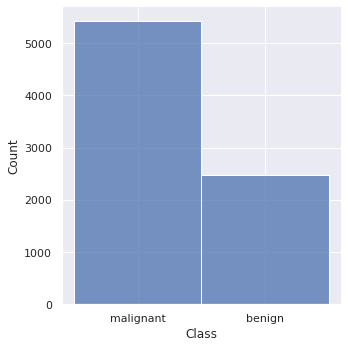

In [ ]:
sns.set_theme()
sns.displot(x='Class', data=data)
data['Class'].value_counts()

In [ ]:
#datax = data[data["Class"]=='benign']
#datax2 = data[data["Class"]=='malignant']
#datax2 = datax2[429:]
#data = pd.concat([datax,datax2])

**Data splits**

In [ ]:
#TEST images samples
test_images = data.groupby(by='Class').sample(496)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)
test_images['Class'].value_counts()

benign       496
malignant    496
Name: Class, dtype: int64

In [ ]:

train_images['Class'].value_counts()

malignant    4933
benign       1984
Name: Class, dtype: int64

In [ ]:
max_count = np.max(train_images.Class.value_counts())
min_count = np.min(train_images.Class.value_counts())

# set number of samples in outer training split
train_images = train_images.groupby('Class').sample(n=min_count, replace=True)   #set n to number of images for class
train_images = train_images.reset_index(drop=True)
print("number of train images:",train_images['Class'].value_counts())

number of train images: benign       1984
malignant    1984
Name: Class, dtype: int64


In [ ]:
#Storing the average of all predictions

main_pred = []
error = []
data_kfold = pd.DataFrame()
# Creating X, Y for training 

train_y = train_images.Class
train_x = train_images.drop(['Class'],axis=1)

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 60
N_SPLIT = 5      #number of foods
TRAIN_PATH = './all_images_dir'

In [ ]:
#callbacks
early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000001,verbose = 1)

**Model initialization**

In [ ]:
def get_model(IMG_SIZE):
    from tensorflow.keras.applications import EfficientNetB3
    pre_trained_model = EfficientNetB3(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
    for layer in pre_trained_model.layers:
        layer.trainable = False

    last_layer = pre_trained_model
    last_output = last_layer.output
    
    x= GlobalAveragePooling2D()(last_output)
    x = layers.Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(pre_trained_model.input, x)

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  metrics=['accuracy'])

    return model

**Kfold loop**

In [ ]:
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
    
test_set = test_generator.flow_from_dataframe(dataframe=test_images, directory=TRAIN_PATH,
                                                 x_col="Image",y_col=None,
                                                 shuffle = False,
                                                 class_mode=None,
                                                 target_size=(IMG_SIZE,IMG_SIZE))

Found 992 validated image filenames.


In [ ]:
#Initializing Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
                                   
validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# k-fold
kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)

# Variable for keeping count of split we are executing
j = 0

# K-fold Train and test for each split
for train_idx, val_idx in list(kfold.split(train_x,train_y)):
    x_train_df = train_images.iloc[train_idx]
    x_valid_df = train_images.iloc[val_idx]
    print("fold:",j+1)
    print("train data:",x_train_df["Class"].value_counts())
    print("valid data:",x_valid_df["Class"].value_counts())
    
    j+=1


    training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, directory=TRAIN_PATH,
                                                 x_col="Image", y_col="Class",
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)
    
    validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, directory=TRAIN_PATH,
                                                 x_col="Image", y_col="Class",
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)
    




    model_test = get_model(IMG_SIZE)
    
    history = model_test.fit_generator( training_set,
                                        validation_data=validation_set,
                                        epochs = EPOCHS,
                                       callbacks = [early_stopping,reduce_lr]
                                        )
    
   
    
    pred= model_test.predict_generator(test_set)
    predicted_class_indices=np.argmax(pred,axis=1)
                                       
    data_kfold[j] = predicted_class_indices
    gc.collect()

fold: 1
train data: benign       1587
malignant    1587
Name: Class, dtype: int64
valid data: benign       397
malignant    397
Name: Class, dtype: int64
Found 3174 validated image filenames belonging to 2 classes.
Found 794 validated image filenames belonging to 2 classes.


2022-03-26 21:32:10.190332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:32:10.298922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:32:10.299743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 21:32:10.301058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-26 21:32:16.268454: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2022-03-26 21:32:16.378849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-03-26 21:32:25.295722: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2022-03-26 21:32:26.190345: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  5/100 [>.............................] - ETA: 40s - loss: 0.7020 - accuracy: 0.5250

2022-03-26 21:32:33.323953: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.


  6/100 [>.............................] - ETA: 41s - loss: 0.7019 - accuracy: 0.5208

2022-03-26 21:32:33.830636: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.


  7/100 [=>............................] - ETA: 42s - loss: 0.6970 - accuracy: 0.5312

2022-03-26 21:32:34.382866: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.


100/100 [==============================] - 80s 653ms/step - loss: 0.6660 - accuracy: 0.6024 - val_loss: 0.6151 - val_accuracy: 0.7317
Epoch 2/60
100/100 [==============================] - 60s 597ms/step - loss: 0.5873 - accuracy: 0.7410 - val_loss: 0.5380 - val_accuracy: 0.7809
Epoch 3/60
100/100 [==============================] - 60s 596ms/step - loss: 0.5202 - accuracy: 0.7848 - val_loss: 0.4735 - val_accuracy: 0.8010
Epoch 4/60
100/100 [==============================] - 60s 599ms/step - loss: 0.4651 - accuracy: 0.8072 - val_loss: 0.4265 - val_accuracy: 0.8199
Epoch 5/60
100/100 [==============================] - 60s 597ms/step - loss: 0.4216 - accuracy: 0.8198 - val_loss: 0.3959 - val_accuracy: 0.8300
Epoch 6/60
100/100 [==============================] - 60s 602ms/step - loss: 0.3909 - accuracy: 0.8390 - val_loss: 0.3643 - val_accuracy: 0.8438
Epoch 7/60
100/100 [==============================] - 60s 601ms/step - loss: 0.3626 - accuracy: 0.8566 - val_loss: 0.3373 - val_accuracy: 0.8

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


fold: 2
train data: benign       1587
malignant    1587
Name: Class, dtype: int64
valid data: benign       397
malignant    397
Name: Class, dtype: int64
Found 3174 validated image filenames belonging to 2 classes.
Found 794 validated image filenames belonging to 2 classes.
Epoch 1/60
100/100 [==============================] - 70s 625ms/step - loss: 0.6584 - accuracy: 0.6389 - val_loss: 0.6134 - val_accuracy: 0.7204
Epoch 2/60
100/100 [==============================] - 60s 600ms/step - loss: 0.5737 - accuracy: 0.7675 - val_loss: 0.5383 - val_accuracy: 0.7758
Epoch 3/60
100/100 [==============================] - 60s 602ms/step - loss: 0.4991 - accuracy: 0.7999 - val_loss: 0.4781 - val_accuracy: 0.7897
Epoch 4/60
100/100 [==============================] - 59s 592ms/step - loss: 0.4386 - accuracy: 0.8185 - val_loss: 0.4334 - val_accuracy: 0.8199
Epoch 5/60
100/100 [==============================] - 60s 596ms/step - loss: 0.3991 - accuracy: 0.8384 - val_loss: 0.4020 - val_accuracy: 0.8249


In [ ]:
# holder
data_kfold

,1,2,3,4,5
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
987,1,1,1,1,1
988,1,1,1,1,0
989,1,1,1,1,1
990,1,1,1,1,1


In [ ]:
# confusion matrix function
import itertools           
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
acc = np.array([])
prec = np.array([])
spec = np.array([])
sens = np.array([])


In [ ]:
# method 1 mean average of k fold method
labels=(training_set.class_indices)
labels2=dict((v,k) for k,v in labels.items())
accuracy1 = []
for i in range(N_SPLIT):
    predicted_class_indices = data_kfold[i+1]
    predictions=[labels2[k] for k in predicted_class_indices]
    accuracy1.append(accuracy_score(predictions,test_images.Class))  

    # Get the labels of the test images.

    test_labels = test_images.Class
    test_labels.shape
    # argmax returns the index of the max value in a row
    cm = confusion_matrix(test_labels, predictions)
    # Define the labels of the class indices. These need to match the 
    # order shown above.
    cm_plot_labels = ['benign', 'malignant']
    
    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[1,0] # false positives
    FN = cm[0,1] # false negatives

    
    TPR = TP/(TP+FN) #Sensitivity
    TNR = TN/(TN+FP) #Specifity
    PPV = TP/(TP+FP) #Precision
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN) #Accuracy

    acc = np.append(acc,ACC)
    prec = np.append(prec,PPV)
    spec = np.append(spec,TNR)
    sens = np.append(sens,TPR)
    print("fold:",i+1)
    print(classification_report(predictions,test_images.Class,digits=3))
    #print(f"Trial Metrics:")
    #print(f"Sensitivity: {TPR}\nSpecifity: {TNR}\nPrecision: {PPV}\nAccuracy: {ACC}")

average = mean(accuracy1)
print("Mean Accuracy of K-Fold Method: ",average)

fold: 1
              precision    recall  f1-score   support

      benign      0.891     0.904     0.897       489
   malignant      0.905     0.893     0.899       503

    accuracy                          0.898       992
   macro avg      0.898     0.898     0.898       992
weighted avg      0.898     0.898     0.898       992

fold: 2
              precision    recall  f1-score   support

      benign      0.877     0.901     0.889       483
   malignant      0.903     0.880     0.892       509

    accuracy                          0.890       992
   macro avg      0.890     0.890     0.890       992
weighted avg      0.890     0.890     0.890       992

fold: 3
              precision    recall  f1-score   support

      benign      0.891     0.877     0.884       504
   malignant      0.875     0.889     0.882       488

    accuracy                          0.883       992
   macro avg      0.883     0.883     0.883       992
weighted avg      0.883     0.883     0.883       

In [ ]:
#acc,prec,spec,sens

print(f"Sensitivity mean: {np.mean(sens)}\nSpecifity mean: {np.mean(spec)}\nPrecision mean: {np.mean(prec)}\nAccuracy mean: {np.mean(acc)}\n")
print(f"Sensitivity STD: {np.std(sens)}\nSpecifity STD: {np.std(spec)}\nPrecision STD: {np.std(prec)}\nAccuracy STD: {np.std(acc)}")

Sensitivity mean: 0.8830433595720741
Specifity mean: 0.8956384780468165
Precision mean: 0.8971774193548387
Accuracy mean: 0.8891129032258064
Sensitivity STD: 0.007910667643959585
Specifity STD: 0.00956681831393084
Precision STD: 0.011261483906265272
Accuracy STD: 0.0054098418810478895


In [ ]:
ans = test_images.copy()

In [ ]:
# method 2
# Taking The Label with Maximum Occurences

labels=(training_set.class_indices)
labels2=dict((v,k) for k,v in labels.items())
import collections 
for i in range(len(data_kfold)):
    co = collections.Counter(data_kfold.loc[i])
    co = sorted(co.items(),key=lambda x: x[1],reverse=True)
    ans.Class.loc[i] = labels2[co[0][0]]
print("Accuracy of K-Fold Maximum Occurences Method: ",accuracy_score(test_images.Class,ans.Class))

Accuracy of K-Fold Maximum Occurences Method:  0.8961693548387096


In [ ]:
# Get the labels of the test images.

test_labels = test_images.Class
test_labels.shape
# argmax returns the index of the max value in a row
cm2 = confusion_matrix(test_labels, ans.Class)
# Print the label associated with each class
 
#print(test_set.class_indices)
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['benign', 'malignant']

Confusion matrix, without normalization
[[442  54]
 [ 49 447]]
Trial Metrics of mac occurence method:
Sensitivity: 0.8922155688622755
Specifity: 0.90020366598778
Precision: 0.9012096774193549
Accuracy: 0.8961693548387096


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


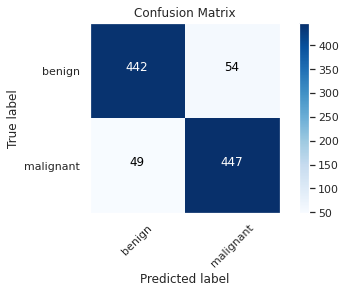

In [ ]:
plot_confusion_matrix(cm2, cm_plot_labels, title='Confusion Matrix')
TP = cm2[1,1] # true positive 
TN = cm2[0,0] # true negatives
FP = cm2[1,0] # false positives
FN = cm2[0,1] # false negatives

    
TPR = TP/(TP+FN) #Sensitivity
TNR = TN/(TN+FP) #Specifity
PPV = TP/(TP+FP) #Precision
NPV = TN/(TN+FN) # Negative predictive value
FPR = FP/(FP+TN) # Fall out or false positive rate
FNR = FN/(TP+FN) # False negative rate
FDR = FP/(TP+FP) # False discovery rate

    # Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN) #Accuracy
print(f"Trial Metrics of mac occurence method:")
print(f"Sensitivity: {TPR}\nSpecifity: {TNR}\nPrecision: {PPV}\nAccuracy: {ACC}")

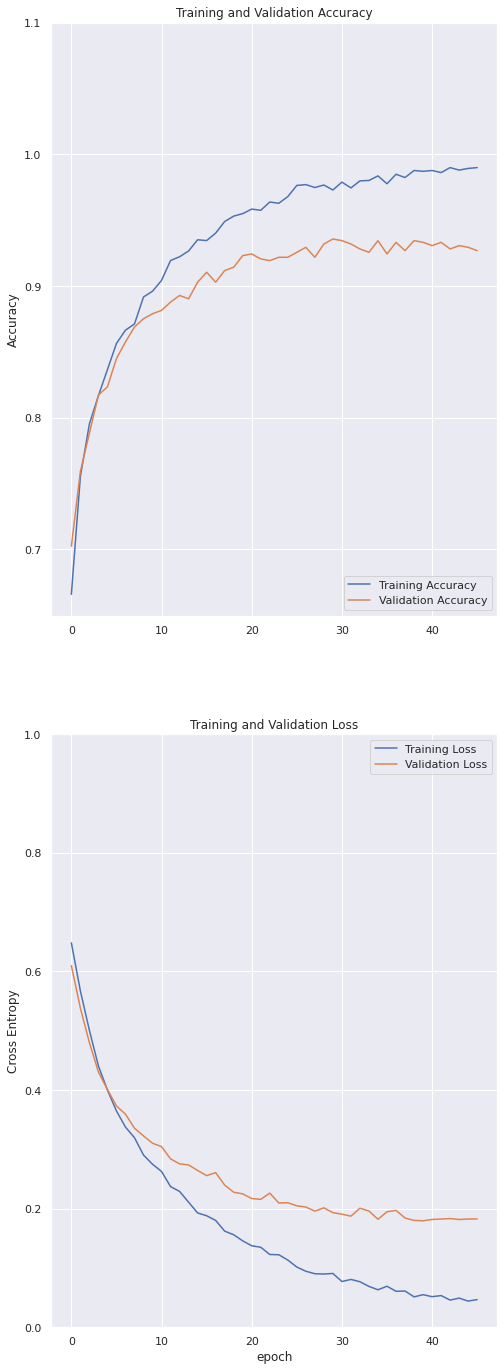

In [ ]:
#learning curves for last fold
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 24))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()